In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lingua import Language, LanguageDetectorBuilder

In [2]:
src = "../eval_results/xlsum/run_true_1_lang_neurons_rescored"
src_ref = "../eval_results/xlsum/run_true_1_rescored"

In [3]:
langs = [
    ("en", Language.ENGLISH),
    ("fr", Language.FRENCH),
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("hi", Language.HINDI),

]

languages = [
    Language.ENGLISH, 
    Language.FRENCH, 
    Language.SPANISH, 
    Language.RUSSIAN, 
    Language.UKRAINIAN, 
    Language.VIETNAMESE, 
    Language.INDONESIAN, 
    Language.CHINESE, 
    Language.HINDI
]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code):
    def lang_filter(row):
        return detector.detect_language_of(str(row["response"])) == l_code
    return lang_filter

quants = [
    (src_ref+"/{lang}/hf_16.csv", "hf 16bit"),
    (src_ref+"/{lang}/rtn_4.csv", "rtn 4bit"),
    (src_ref+"/{lang}/awq_4.csv", "awq 4bit"),
    # (src+"/{lang}/mpq_4_ln.csv", "mpq 4bit ln"),
    # (src+"/{lang}/mpq_4_random.csv", "mpq 4bit rng"),
    # (src+"/{lang}/mprq_4_ln.csv", "mprq 4bit ln"),
    # (src+"/{lang}/mprq_4_random.csv", "mprq 4bit rng"),
    (src+"/{lang}/twq_4_ln.csv", "twq 4bit ln"),
    (src+"/{lang}/twq_4_random.csv", "twq 4bit rng"),
]

In [4]:
def prep_data_per_lang(metrics, path, filter_out=False):
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        if filter_out:
            data = data[data.apply(get_filter(l_code), axis=1)]
        data["Languages:"] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    melted = pd.melt(merge, id_vars=["Languages:"], value_vars=metrics, var_name='')
    return melted

In [5]:
def prep_data_per_quant(lang_col_name, quant_col_name, filter_out=False):
    bigmerge = None
    for path, name in quants:
        merge = None
        for lang, l_code in langs:
            data = pd.read_csv(path.format(lang=lang), index_col=0)
            if filter_out:
                data = data[data.apply(get_filter(l_code), axis=1)]
            data[lang_col_name] = lang
            if merge is None:
                merge = data
            else:
                merge = pd.concat([merge, data])
        merge[quant_col_name] = name
        if bigmerge is None:
            bigmerge = merge
        else:
            bigmerge = pd.concat([bigmerge, merge])
    return bigmerge

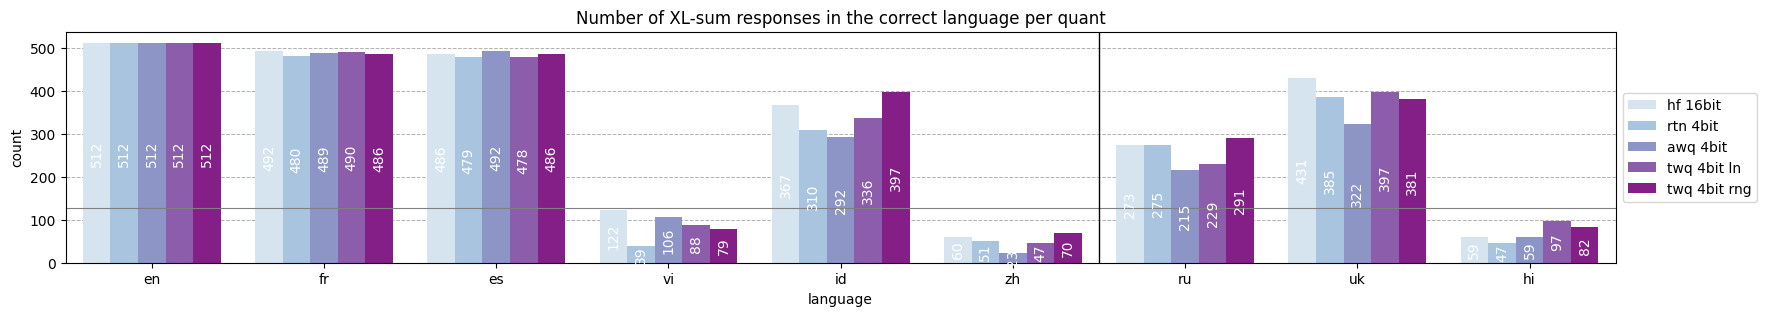

In [6]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

bigmerge = None
for path, name in quants:
    merge = None
    for lang, l_code in langs:
        data = pd.read_csv(path.format(lang=lang), index_col=0)
        # data = data[data.apply(get_filter(l_code), axis=1)]
        data[target_metric] = data.apply(get_filter(l_code), axis=1).sum()
        data[lang_col_name] = lang
        if merge is None:
            merge = data
        else:
            merge = pd.concat([merge, data])
    merge[quant_col_name] = name
    if bigmerge is None:
        bigmerge = merge
    else:
        bigmerge = pd.concat([bigmerge, merge])
        
# melted = pd.melt(merge, id_vars=["Languages:"], value_vars=['rouge1', 'rouge2', 'rougeL'], var_name='')
# melted = pd.melt(merge, id_vars=["Languages:"], value_vars=['rouge1', 'rouge2', 'rougeL', 'rouge1_recall', 'rouge2_recall', 'rougeL_recall'], var_name='')

plt.figure(figsize=(20, 3), dpi=100)
plt.axhline(y=128, color='gray', linestyle='-', linewidth=0.8)
plt.axvline(x=5.5, color='black', linestyle='-', linewidth=1)
ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="BuPu", data=bigmerge, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white")
    for label in labels:
        label.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Number of XL-sum responses in the correct language per quant")

ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)

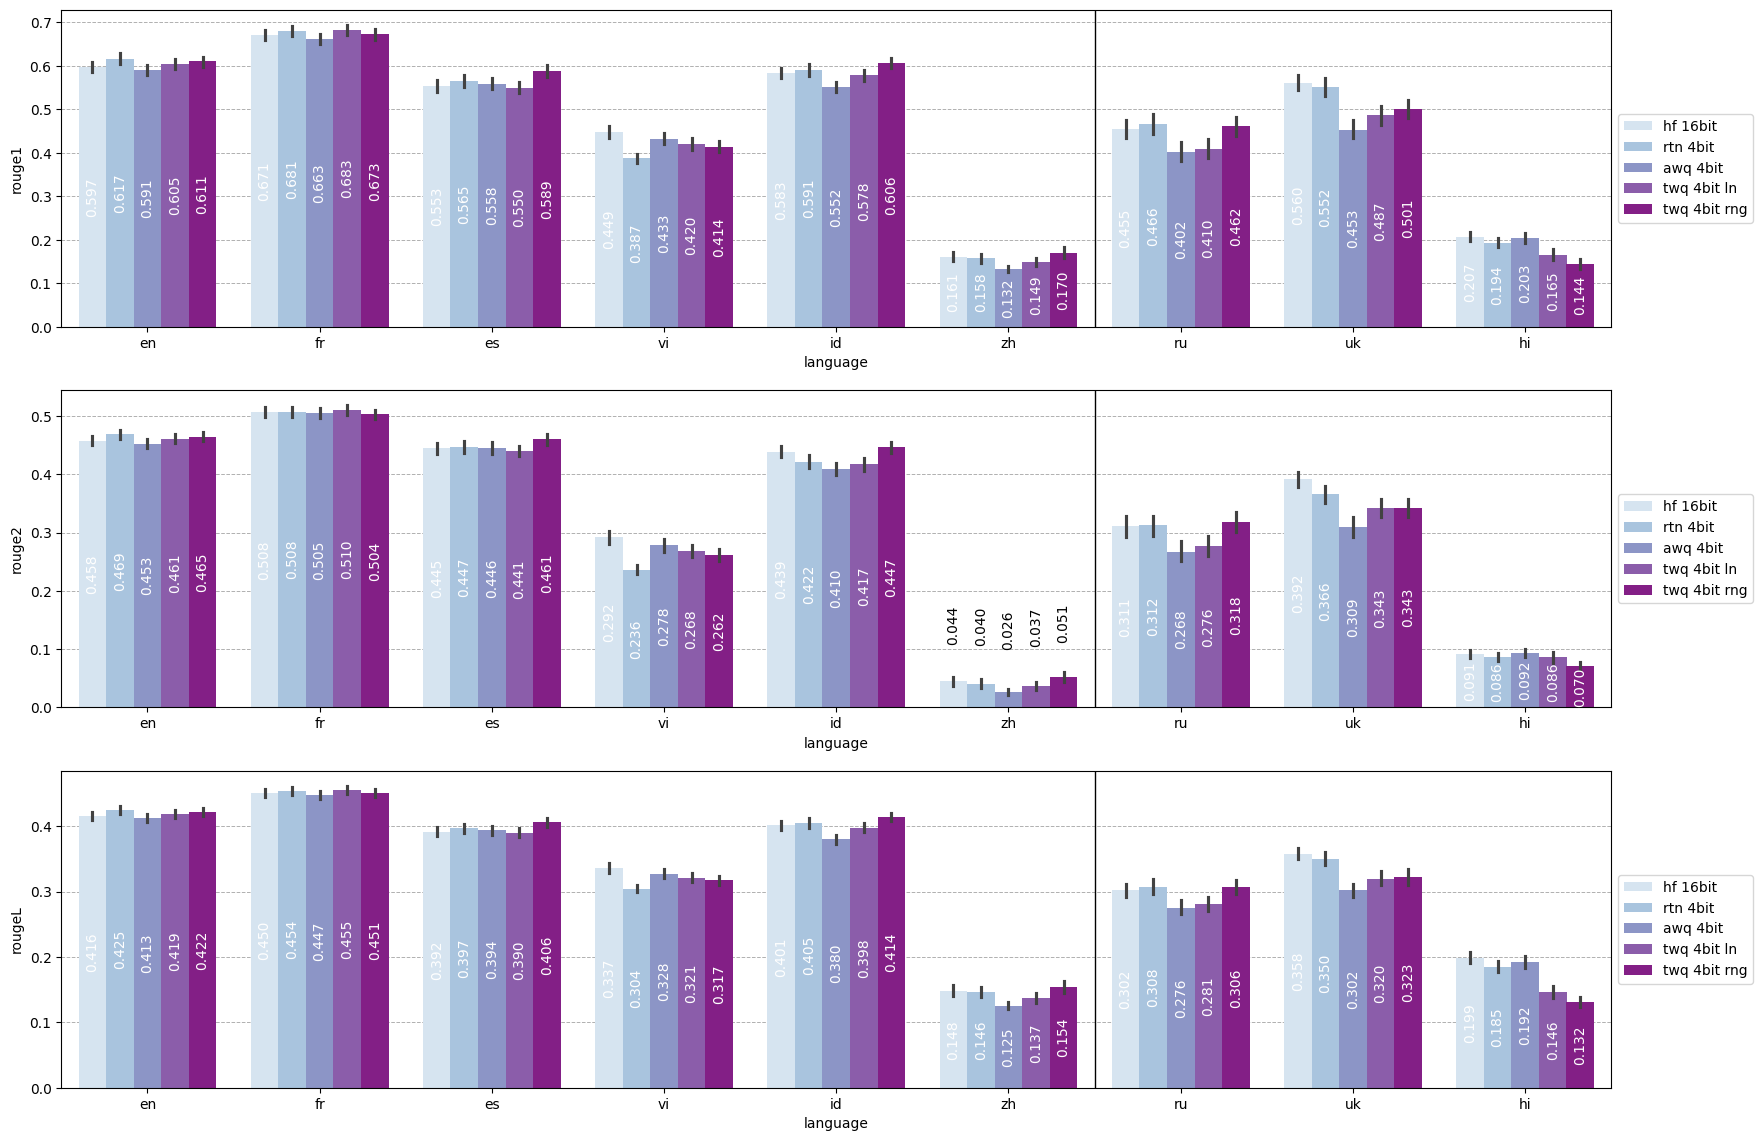

In [7]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = ['rouge1', 'rouge2', 'rougeL']

fig, axs = plt.subplots(3, 1, figsize=(20, 14), dpi=100)
# fig.suptitle("XL-sum ROUGE scores for targeted quants")
for n in range(3):
    sns.barplot(x=lang_col_name, y=target_metrics[n], hue=quant_col_name, palette="BuPu", saturation=1, ax=axs[n],
                data=prep_data_per_quant(lang_col_name, quant_col_name))
    axs[n].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[n].axvline(x=5.5, color='black', linestyle='-', linewidth=1)
    for container in axs[n].containers:
        labels = axs[n].bar_label(container, label_type="center", color="white", padding=0, fmt='%.3f')
        for i, label in enumerate(labels):
            label.set_rotation(90)
            if n == 1 and i in [5]:
                label.set_position([label.xyann[0], label.xyann[1] + 50])
                label.set_color("black")
    
    # axs[n].set_ylim(0.2, 0.6 if n == 0 else 0.45)
    axs[n].grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    axs[n].set_axisbelow(True)

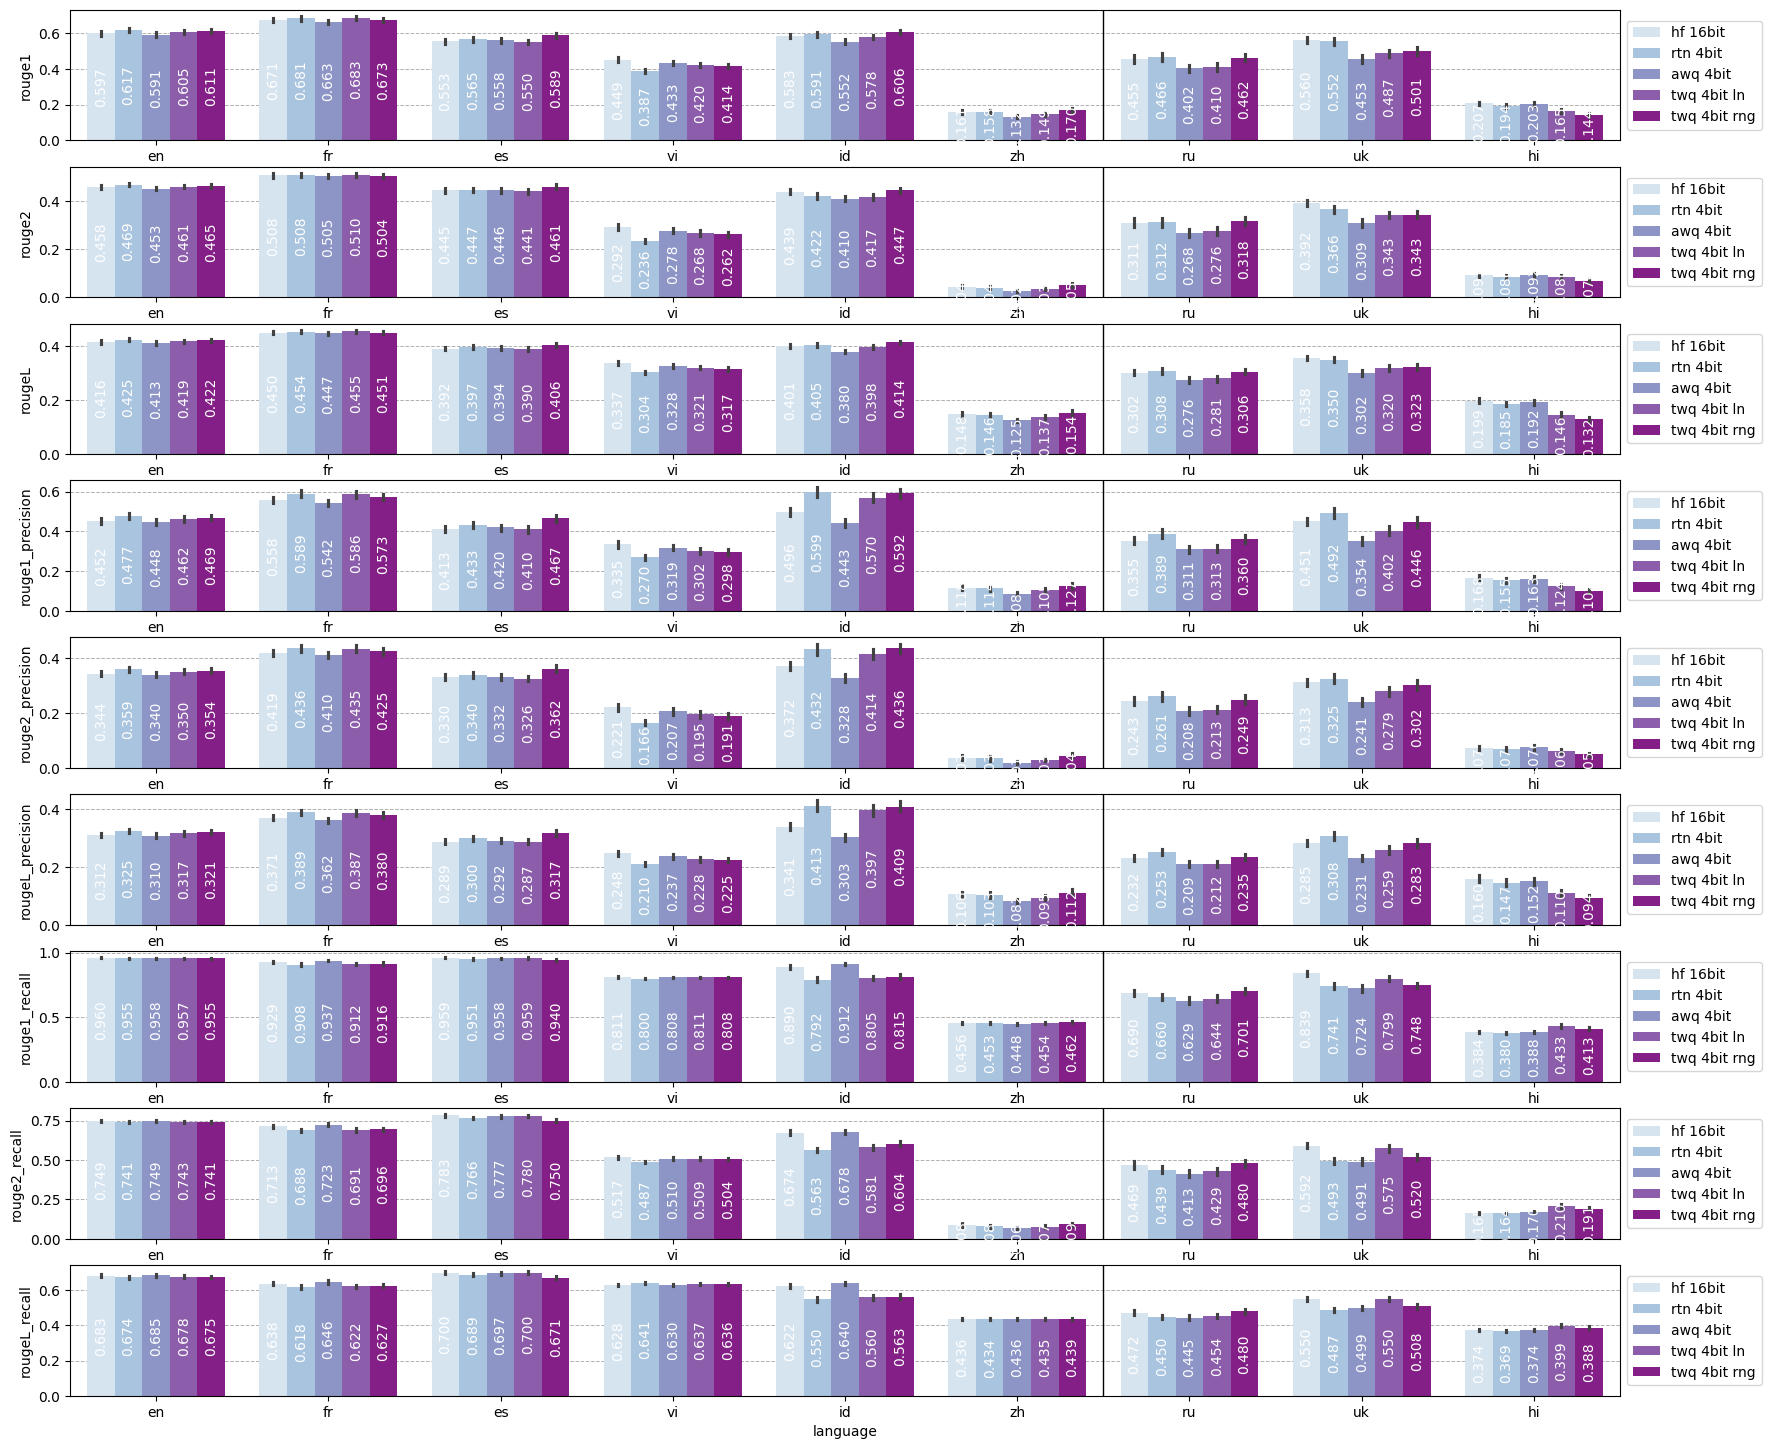

In [8]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metrics = [
    "rouge1",
    "rouge2",
    "rougeL",
    "rouge1_precision",
    "rouge2_precision",
    "rougeL_precision",
    "rouge1_recall",
    "rouge2_recall",
    "rougeL_recall",
]


fig, axs = plt.subplots(9, 1, figsize=(20, 18), dpi=100)
# fig.suptitle("XL-sum ROUGE scores for targeted quants")
for n in range(9):
    sns.barplot(x=lang_col_name, y=target_metrics[n], hue=quant_col_name, palette="BuPu", saturation=1, ax=axs[n],
                data=prep_data_per_quant(lang_col_name, quant_col_name))
    axs[n].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[n].axvline(x=5.5, color='black', linestyle='-', linewidth=1)
    for container in axs[n].containers:
        labels = axs[n].bar_label(container, label_type="center", color="white", padding=0, fmt='%.3f')
        for i, label in enumerate(labels):
            label.set_rotation(90)
            # if n == 1 and i in [5, 8]:
            #     label.set_position([label.xyann[0], label.xyann[1] + 50])
            #     label.set_color("black")
    
    axs[n].grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    axs[n].set_axisbelow(True)